# Часть 1

Задача - разработать рекомендательную систему по выявлению опасных дорожных участков и предотвращению будущих дорожно-транспортных происшествий на территории регионов Российской Федерации. 

---

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import json
import glob
from feature_selector import FeatureSelector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', 500)

### 1.1 Парсинг данных

In [2]:
q = pd.read_json('data/altaiskii-krai.geojson')

Преобразование всех geojson документов в единый DataFram

In [3]:
df = pd.DataFrame()
#Разбор значений из json в DataFrame (df)
for filename in glob.glob("data/*.geojson"): #Перебрать все файлы
    with open(filename, encoding='utf-8-sig') as json_data:  #Открытие каждого файла по очереди
        data = json.load(json_data)#Загрузите файл и поместите его в переменную данных
    #Разбор вложженостей данных
    df1 = pd.json_normalize(data['features'], errors='ignore')
    df2 = pd.json_normalize(data['features'], record_path=['properties', 'vehicles'], meta=[['properties',  'id']], errors='ignore')
    df3 = pd.json_normalize(data['features'], record_path=['properties', 'vehicles', 'participants'], meta=[['properties',  'id']], errors='ignore')
    df4 = pd.json_normalize(data['features'], record_path=['properties', 'participants'], meta=[['properties',  'id']], errors='ignore')
    #Обьединение всех файлов в единый набор данных
    dft = df1.merge(df2, on = ('properties.id'))
    dft = dft.merge(df3, on = ('properties.id'))
    df = pd.concat([df, dft.merge(df4, on = ('properties.id'), how='left', suffixes=('_driver', '_ped'))])

In [4]:
df

,type,geometry.type,geometry.coordinates,properties.id,properties.tags,properties.light,properties.point.lat,properties.point.long,properties.nearby,properties.region,properties.scheme,properties.address,properties.weather,properties.category,properties.datetime,properties.severity,properties.vehicles,properties.dead_count,properties.participants,properties.injured_count,properties.parent_region,properties.road_conditions,properties.participants_count,properties.participant_categories,year,brand,color,model,category,participants,role_driver,gender_driver,violations_driver,health_status_driver,years_of_driving_experience,role_ped,gender_ped,violations_ped,health_status_ped
0,Feature,Point,"[83.6903, 53.342]",2311491,[Дорожно-транспортные происшествия],"В темное время суток, освещение отсутствует",53.342000,83.690300,"[Многоквартирные жилые дома, Административные ...",Барнаул,610,"г Барнаул, тракт Павловский, 249 а",[Ясно],Наезд на препятствие,2017-09-04 22:15:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'Ч...",0,[],1,Алтайский край,[Сухое],2,[Все участники],2002.0,TOYOTA,Черный,Camry,"С-класс (малый средний, компактный) до 4,3 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",Водитель,Мужской,"[Другие нарушения ПДД водителем, Нарушение вод...",Не пострадал,NaN,NaN,NaN,NaN,NaN
1,Feature,Point,"[83.6903, 53.342]",2311491,[Дорожно-транспортные происшествия],"В темное время суток, освещение отсутствует",53.342000,83.690300,"[Многоквартирные жилые дома, Административные ...",Барнаул,610,"г Барнаул, тракт Павловский, 249 а",[Ясно],Наезд на препятствие,2017-09-04 22:15:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'Ч...",0,[],1,Алтайский край,[Сухое],2,[Все участники],2002.0,TOYOTA,Черный,Camry,"С-класс (малый средний, компактный) до 4,3 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",Пассажир,Женский,[Нарушение правил применения ремней безопаснос...,"Раненый, находящийся (находившийся) на амбула...",NaN,NaN,NaN,NaN,NaN
2,Feature,Point,"[83.699802, 53.369248]",2489516,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.369248,83.699802,"[Многоквартирные жилые дома, Нерегулируемый пе...",Барнаул,300,"г Барнаул, ул Юрина, 241",[Дождь],Столкновение,2020-09-24 09:30:00,Легкий,"[{'year': 2006, 'brand': 'SUBARU', 'color': 'С...",0,[],2,Алтайский край,[Мокрое],3,"[Дети, Все участники]",2006.0,SUBARU,Серый,Forester,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",Водитель,Мужской,[Несоответствие скорости конкретным условиям д...,"Раненый, находящийся (находившийся) на амбулат...",12.0,NaN,NaN,NaN,NaN
3,Feature,Point,"[83.699802, 53.369248]",2489516,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.369248,83.699802,"[Многоквартирные жилые дома, Нерегулируемый пе...",Барнаул,300,"г Барнаул, ул Юрина, 241",[Дождь],Столкновение,2020-09-24 09:30:00,Легкий,"[{'year': 2006, 'brand': 'SUBARU', 'color': 'С...",0,[],2,Алтайский край,[Мокрое],3,"[Дети, Все участники]",2006.0,SUBARU,Серый,Forester,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбулат...",NaN,NaN,NaN,NaN,NaN
4,Feature,Point,"[83.699802, 53.369248]",2489516,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.369248,83.699802,"[Многоквартирные жилые дома, Нерегулируемый пе...",Барнаул,300,"г Барнаул, ул Юрина, 241",[Дождь],Столкновение,2020-09-24 09:30:00,Легкий,"[{'year': 2006, 'brand': 'SUBARU', 'color': 'С...",0,[],2,Алтайский край,[Мокрое],3,"[Дети, Все участники]",2006.0,SUBARU,Серый,Forester,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",Водитель,Мужской,[],Не пострадал,29.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33286,Feature,Point,"[45.717062, 48.587381]",2118681,"[Дорожно-транспортные происшеств

Удаляем ненужные столбцы, которые содержат не спаршеные данные, а так же стобцы которые не несут в себе полезных данных

In [5]:
df.drop(['type', 'geometry.type', 'participants', 'geometry.coordinates', 'properties.vehicles', 'properties.participants'], axis=1, inplace=True)

### 1.2 Предобработка данных и выделение значимых атрибутов

Оставил только уникальные id и координаты (так как не имея координат невозможно обозначить опасную зону)

In [6]:
df.drop_duplicates(subset=['properties.id'], inplace=True)
df.dropna(subset=['properties.point.lat'], inplace=True)
df.dropna(subset=['properties.point.long'], inplace=True)

Реиндексация

In [7]:
df.reset_index(drop=True, inplace=True)

Количество уникальных идентификаторов

In [8]:
len(df['properties.id'].unique())

45755

Статистика нанов

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45755 entries, 0 to 45754
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   properties.id                      45755 non-null  object 
 1   properties.tags                    45755 non-null  object 
 2   properties.light                   45755 non-null  object 
 3   properties.point.lat               45755 non-null  float64
 4   properties.point.long              45755 non-null  float64
 5   properties.nearby                  45755 non-null  object 
 6   properties.region                  45755 non-null  object 
 7   properties.scheme                  43172 non-null  object 
 8   properties.address                 43817 non-null  object 
 9   properties.weather                 45755 non-null  object 
 10  properties.category                45755 non-null  object 
 11  properties.datetime                45755 non-null  obj

Количество нанов у каждого атрибута

In [10]:
df.isna().sum()

properties.id                            0
properties.tags                          0
properties.light                         0
properties.point.lat                     0
properties.point.long                    0
properties.nearby                        0
properties.region                        0
properties.scheme                     2583
properties.address                    1938
properties.weather                       0
properties.category                      0
properties.datetime                      0
properties.severity                      0
properties.dead_count                    0
properties.injured_count                 0
properties.parent_region                 0
properties.road_conditions               0
properties.participants_count            0
properties.participant_categories        0
year                                  1723
brand                                 1637
color                                 1096
model                                 1638
category   

Анализ плотности распределения данных

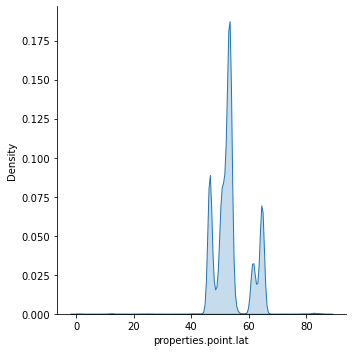

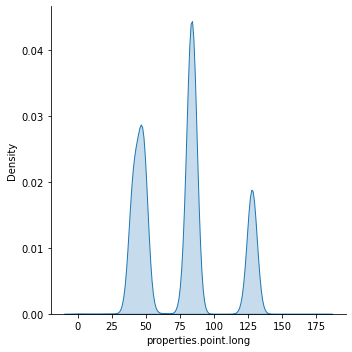

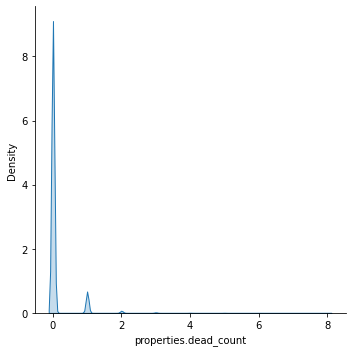

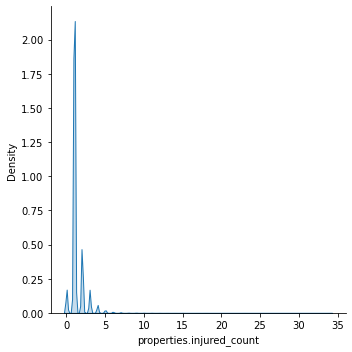

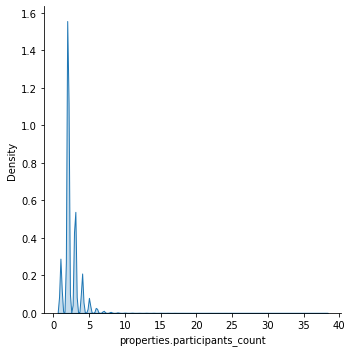

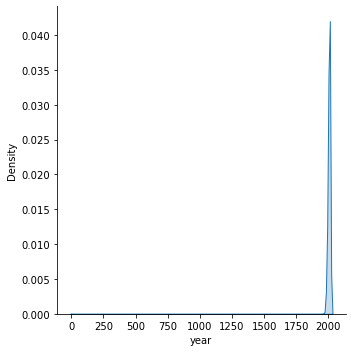

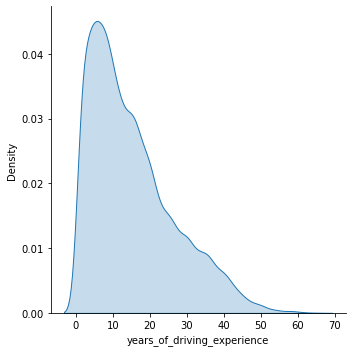

In [11]:
for i in df.columns:
    if type(df[i].iloc[0]) == np.int64 or type(df[i].iloc[0]) == np.float64:
        sns.displot(df, x=i, kind="kde", fill=True)

На графиках распределения выше можно увидеть что не категорильные данные распределены не ровномерно <br>
Большенство сглаженных распределений стремятся к нормальному распределеию, данные не имеют аномальных значений

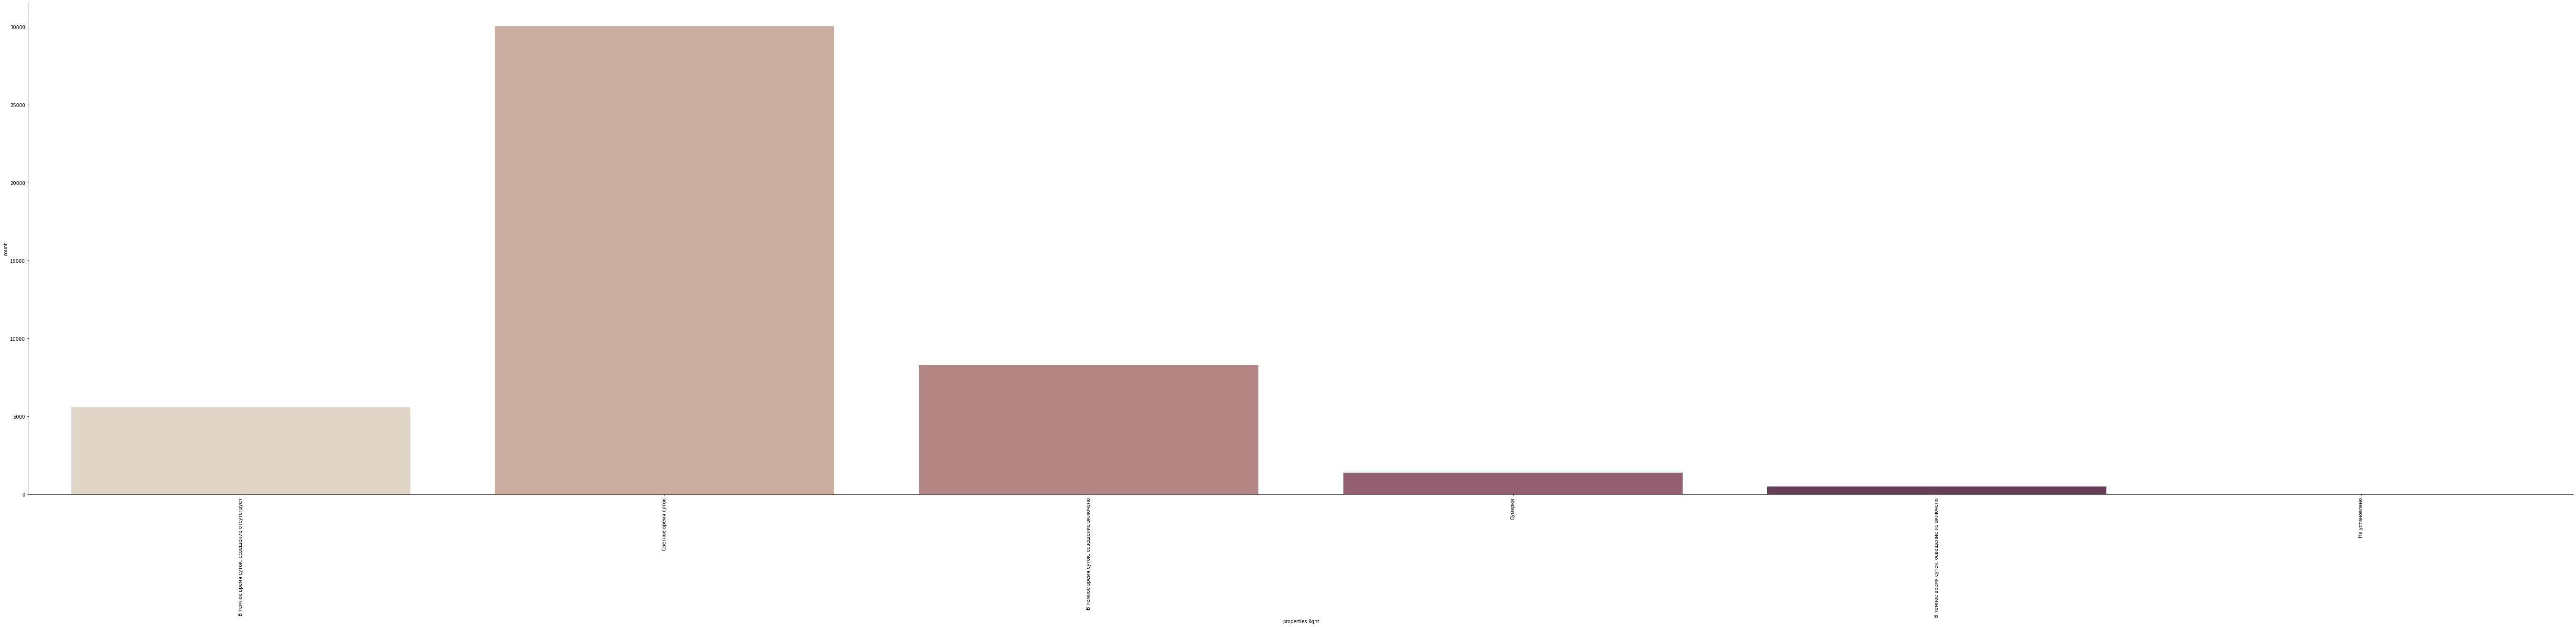

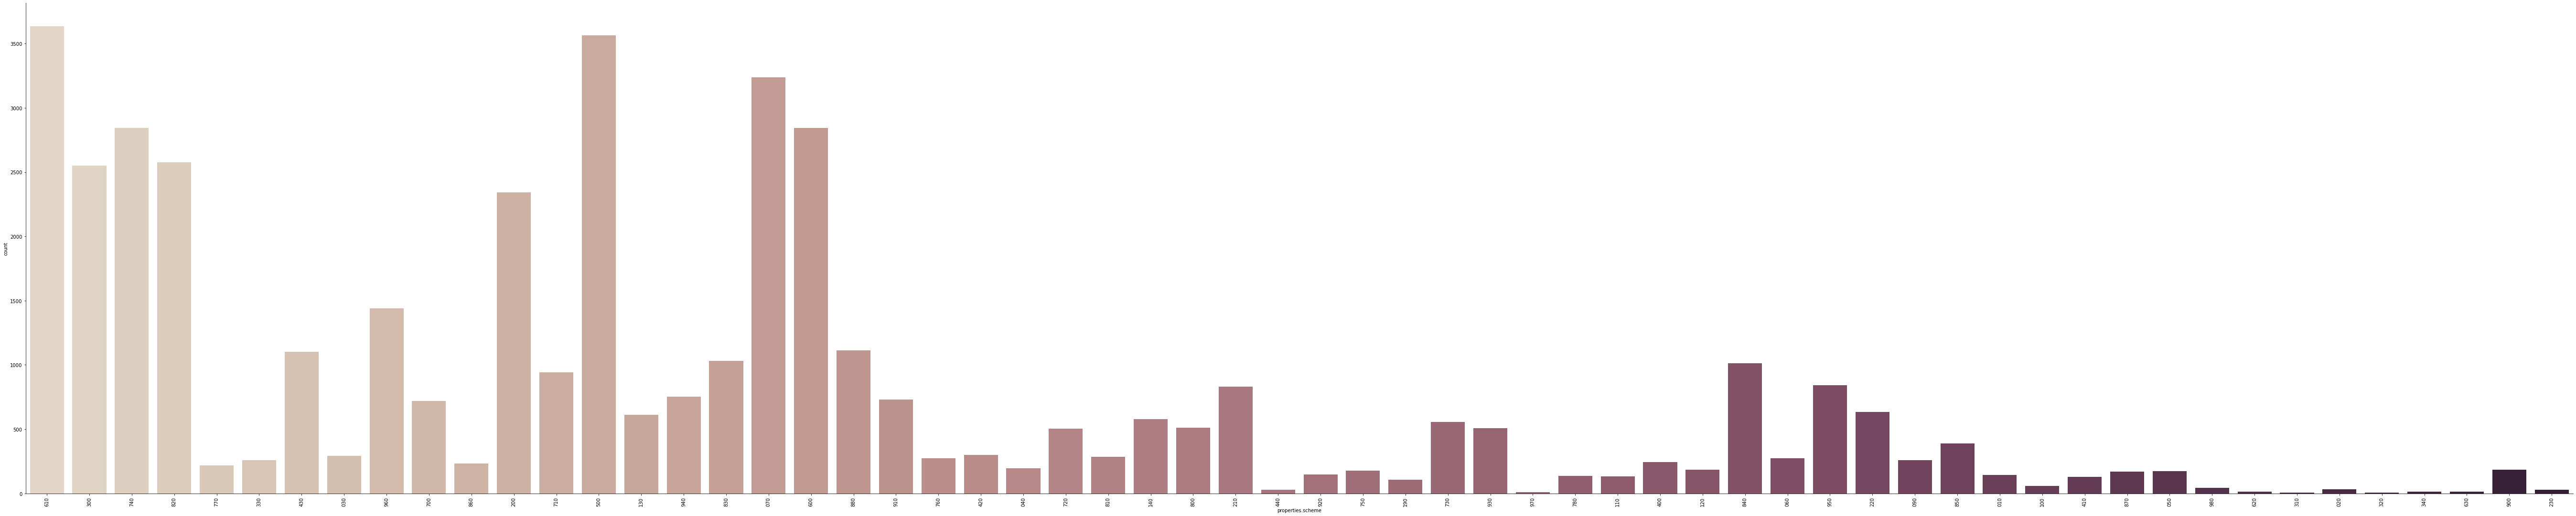

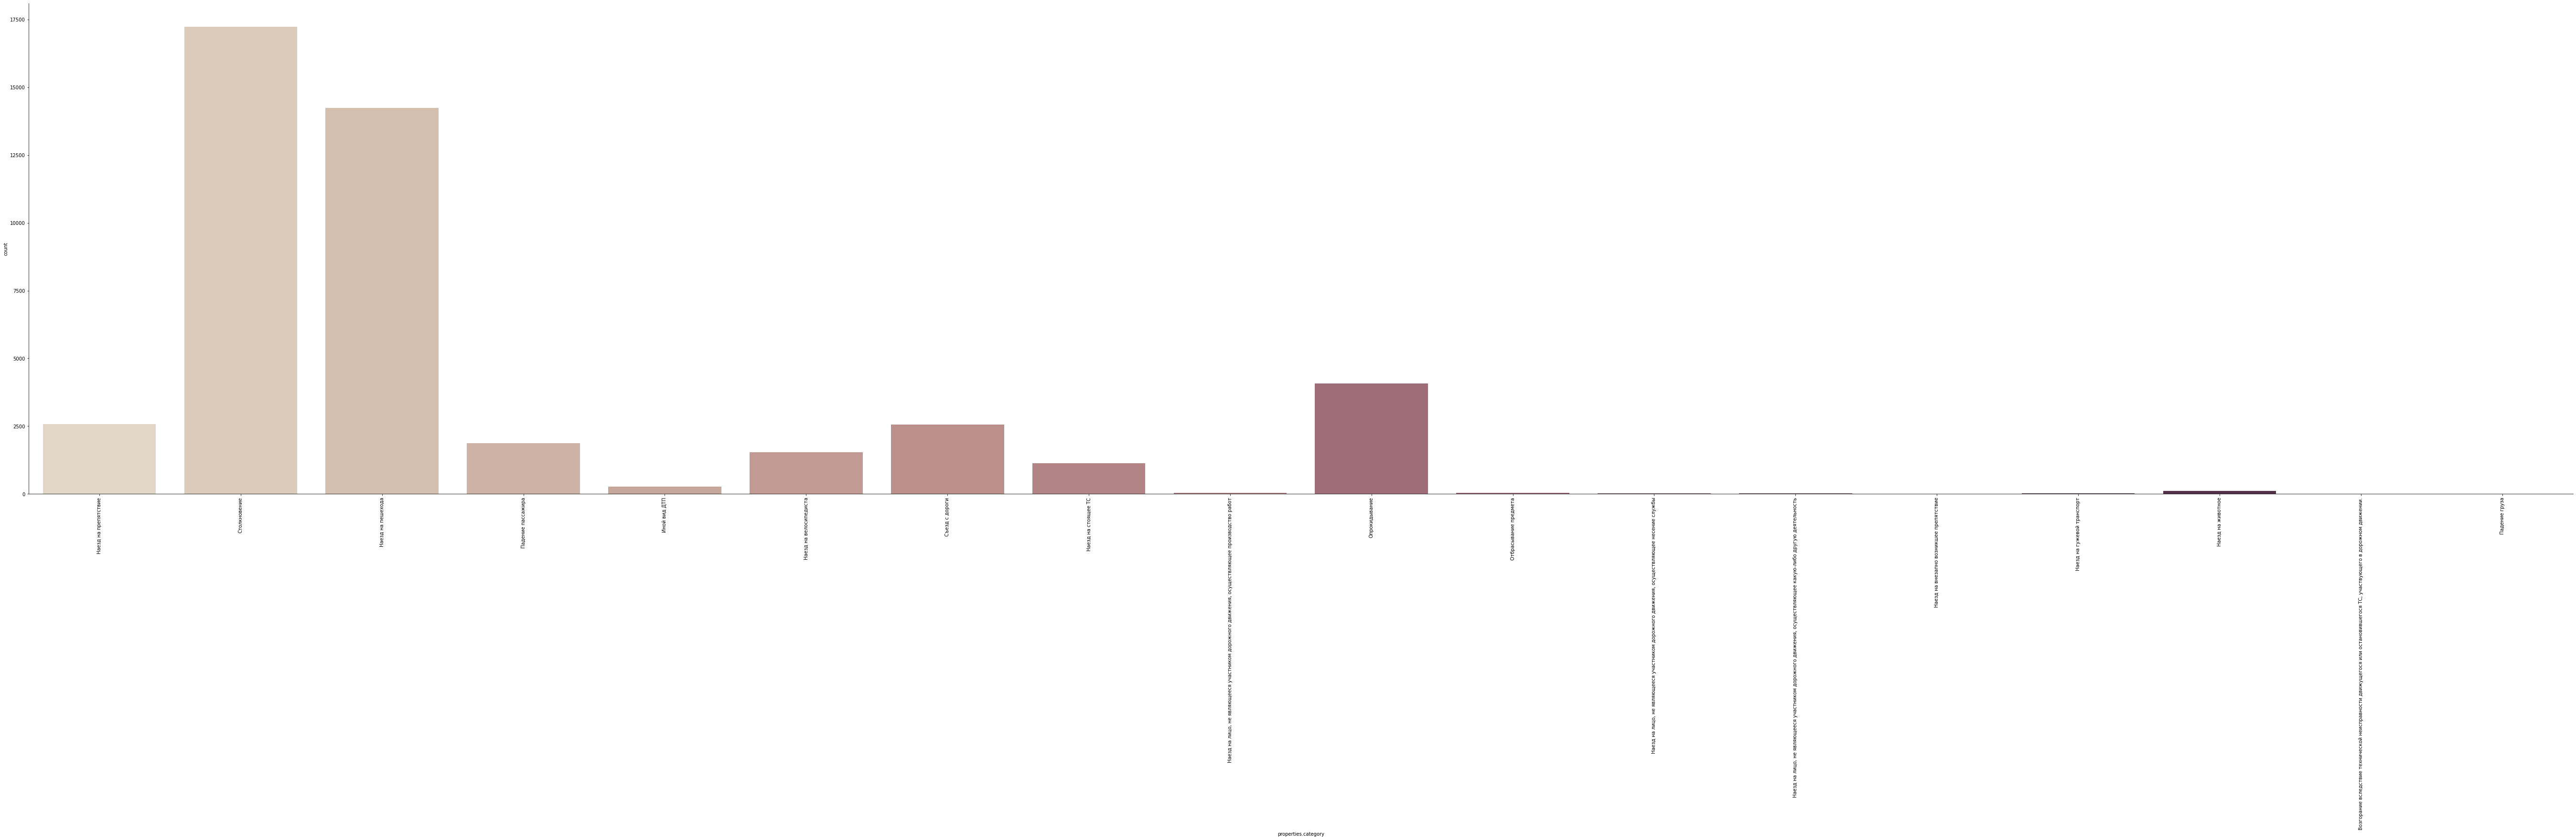

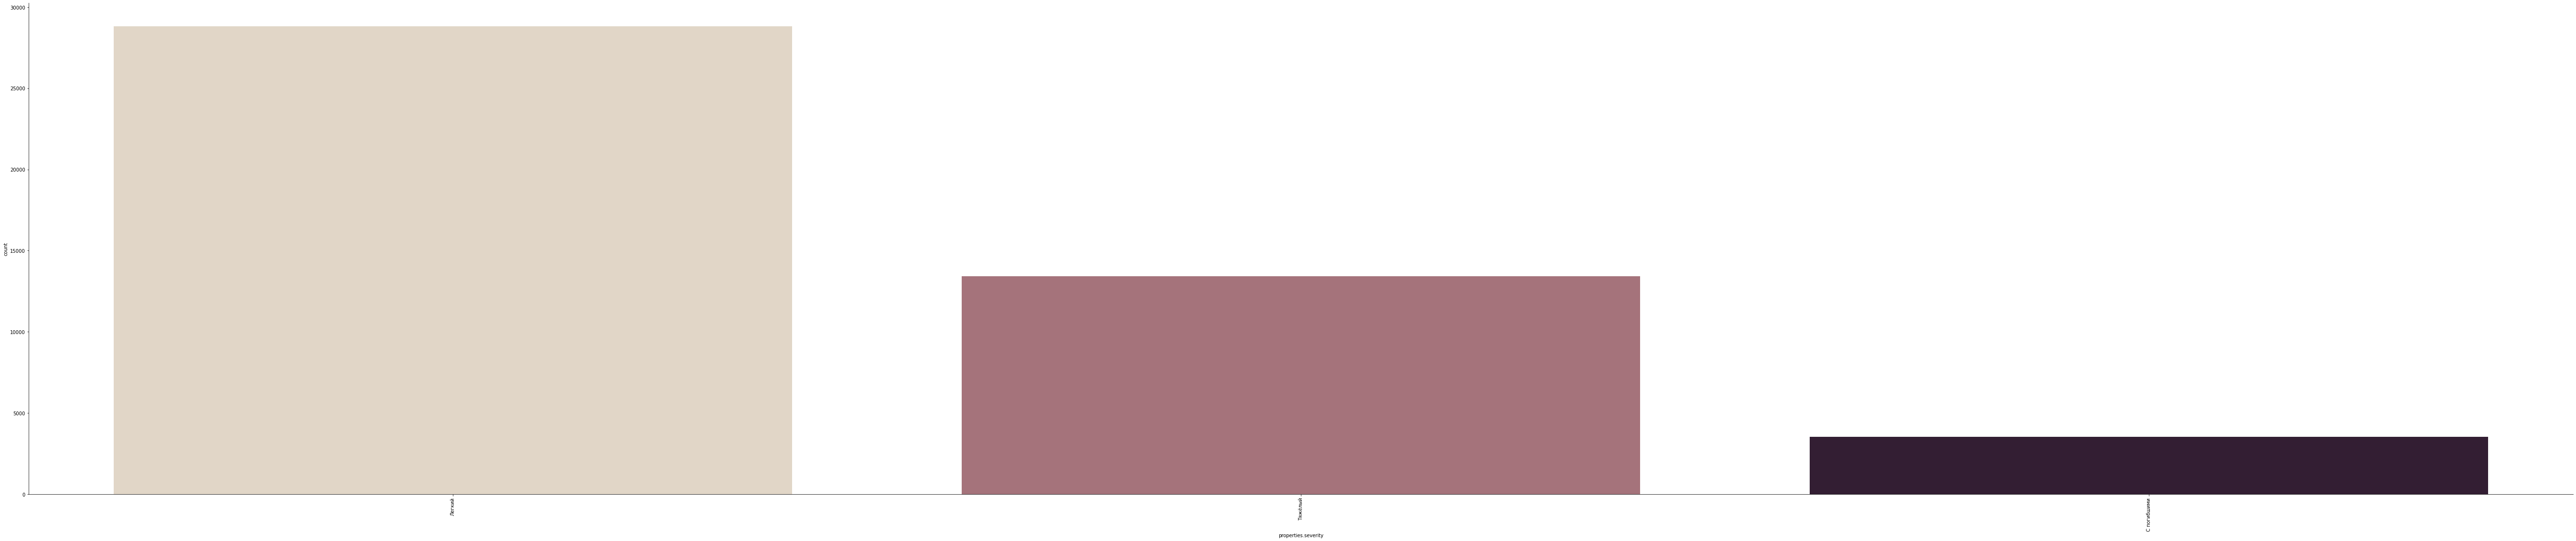

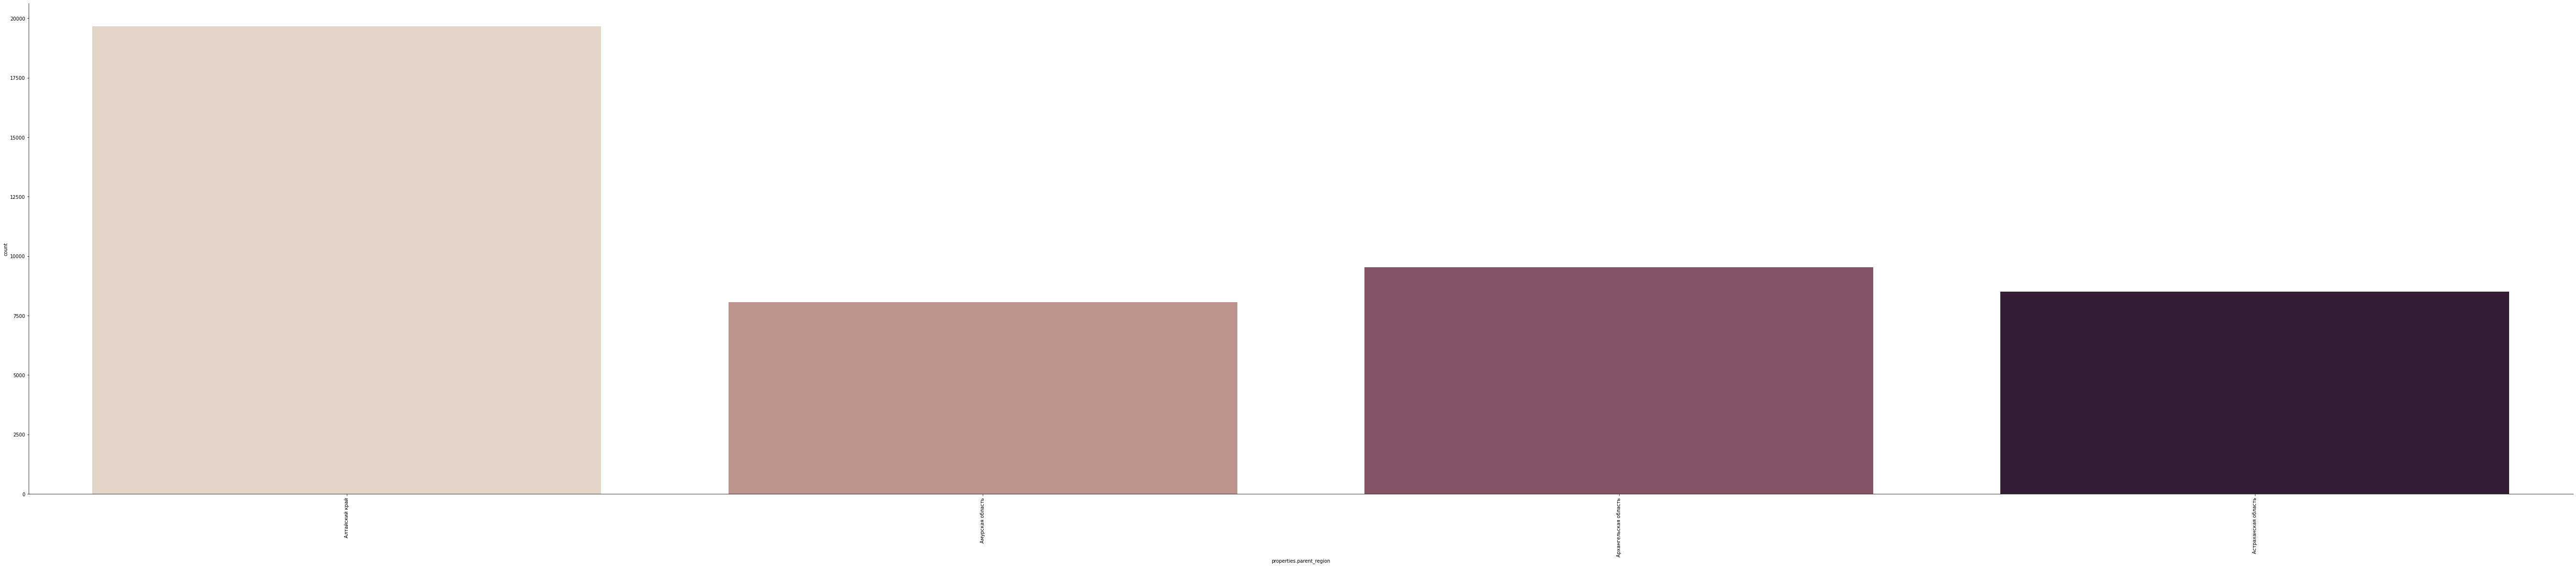

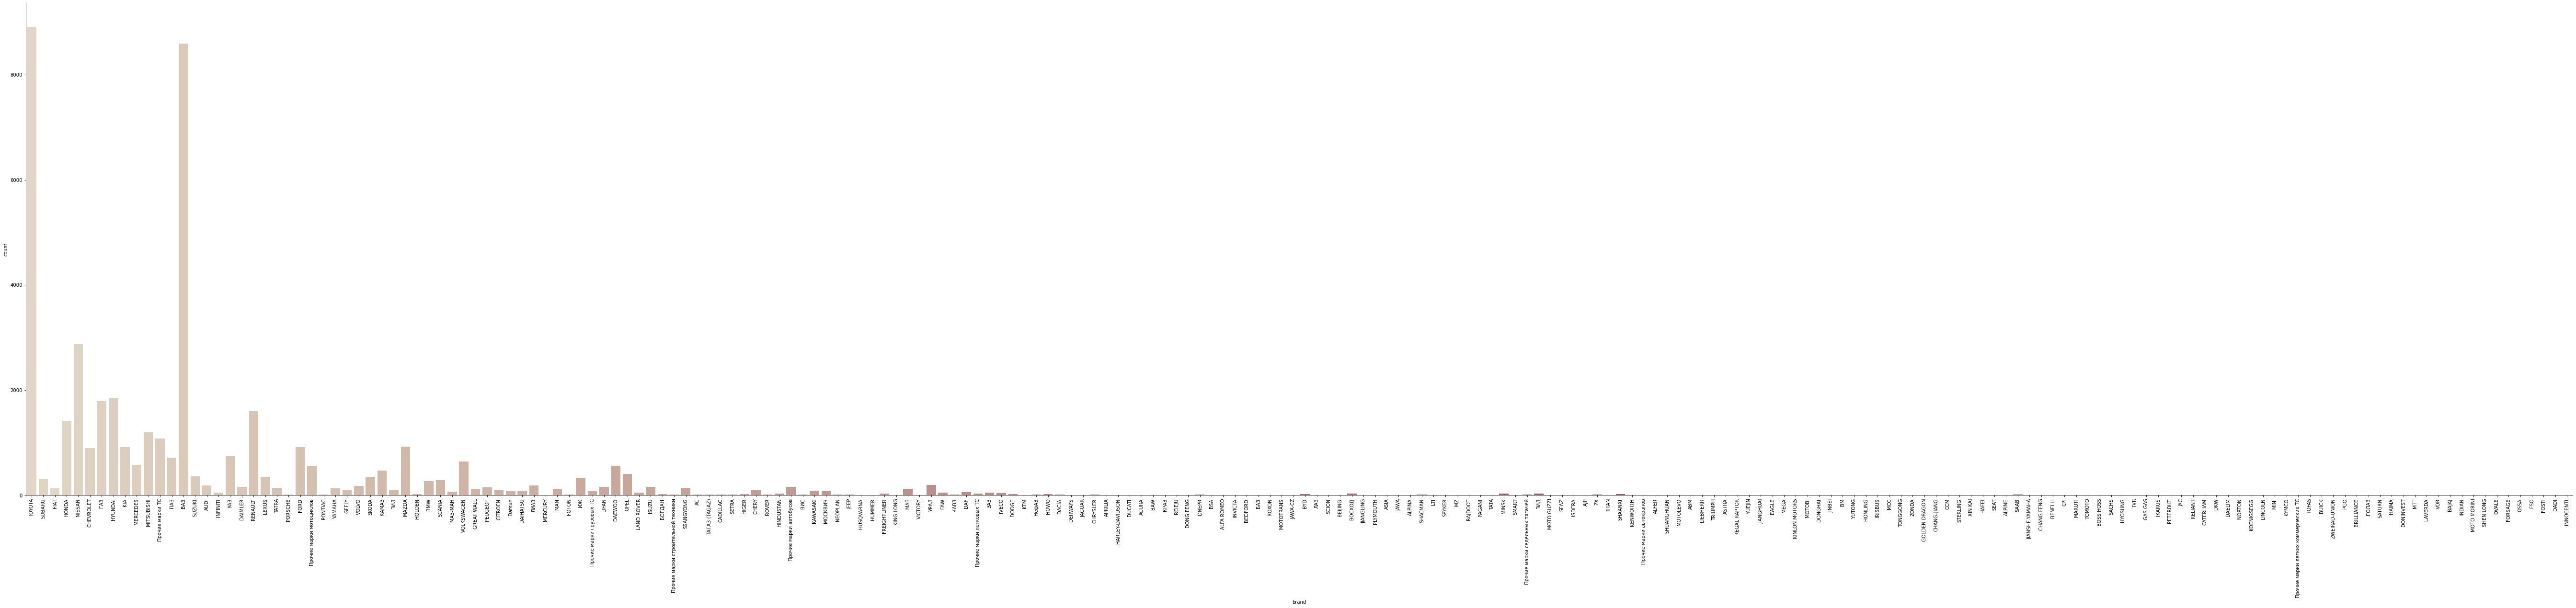

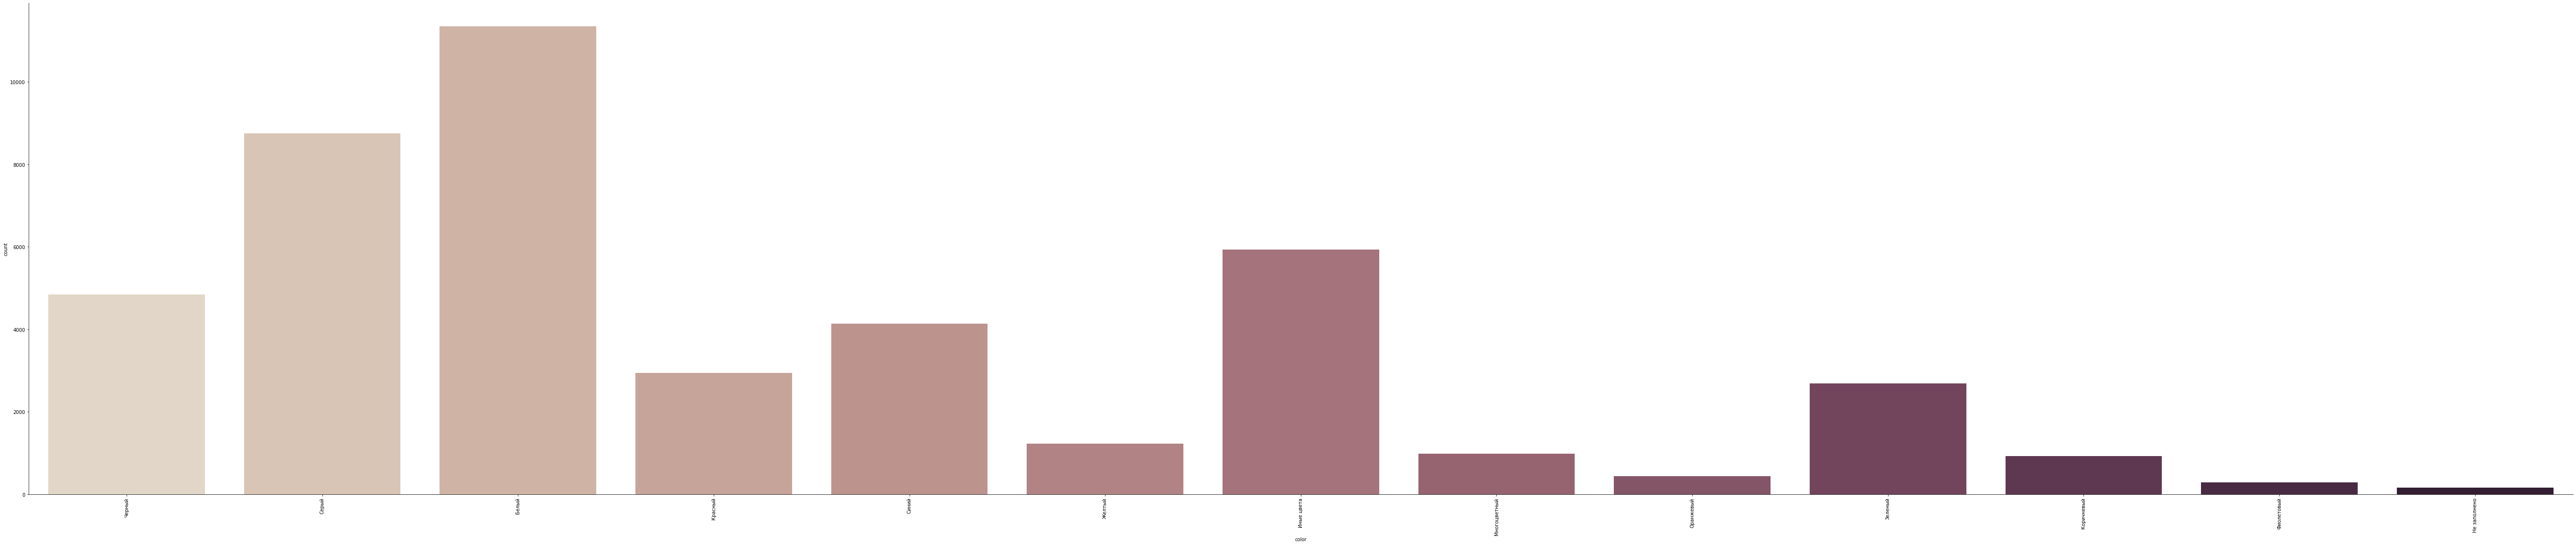

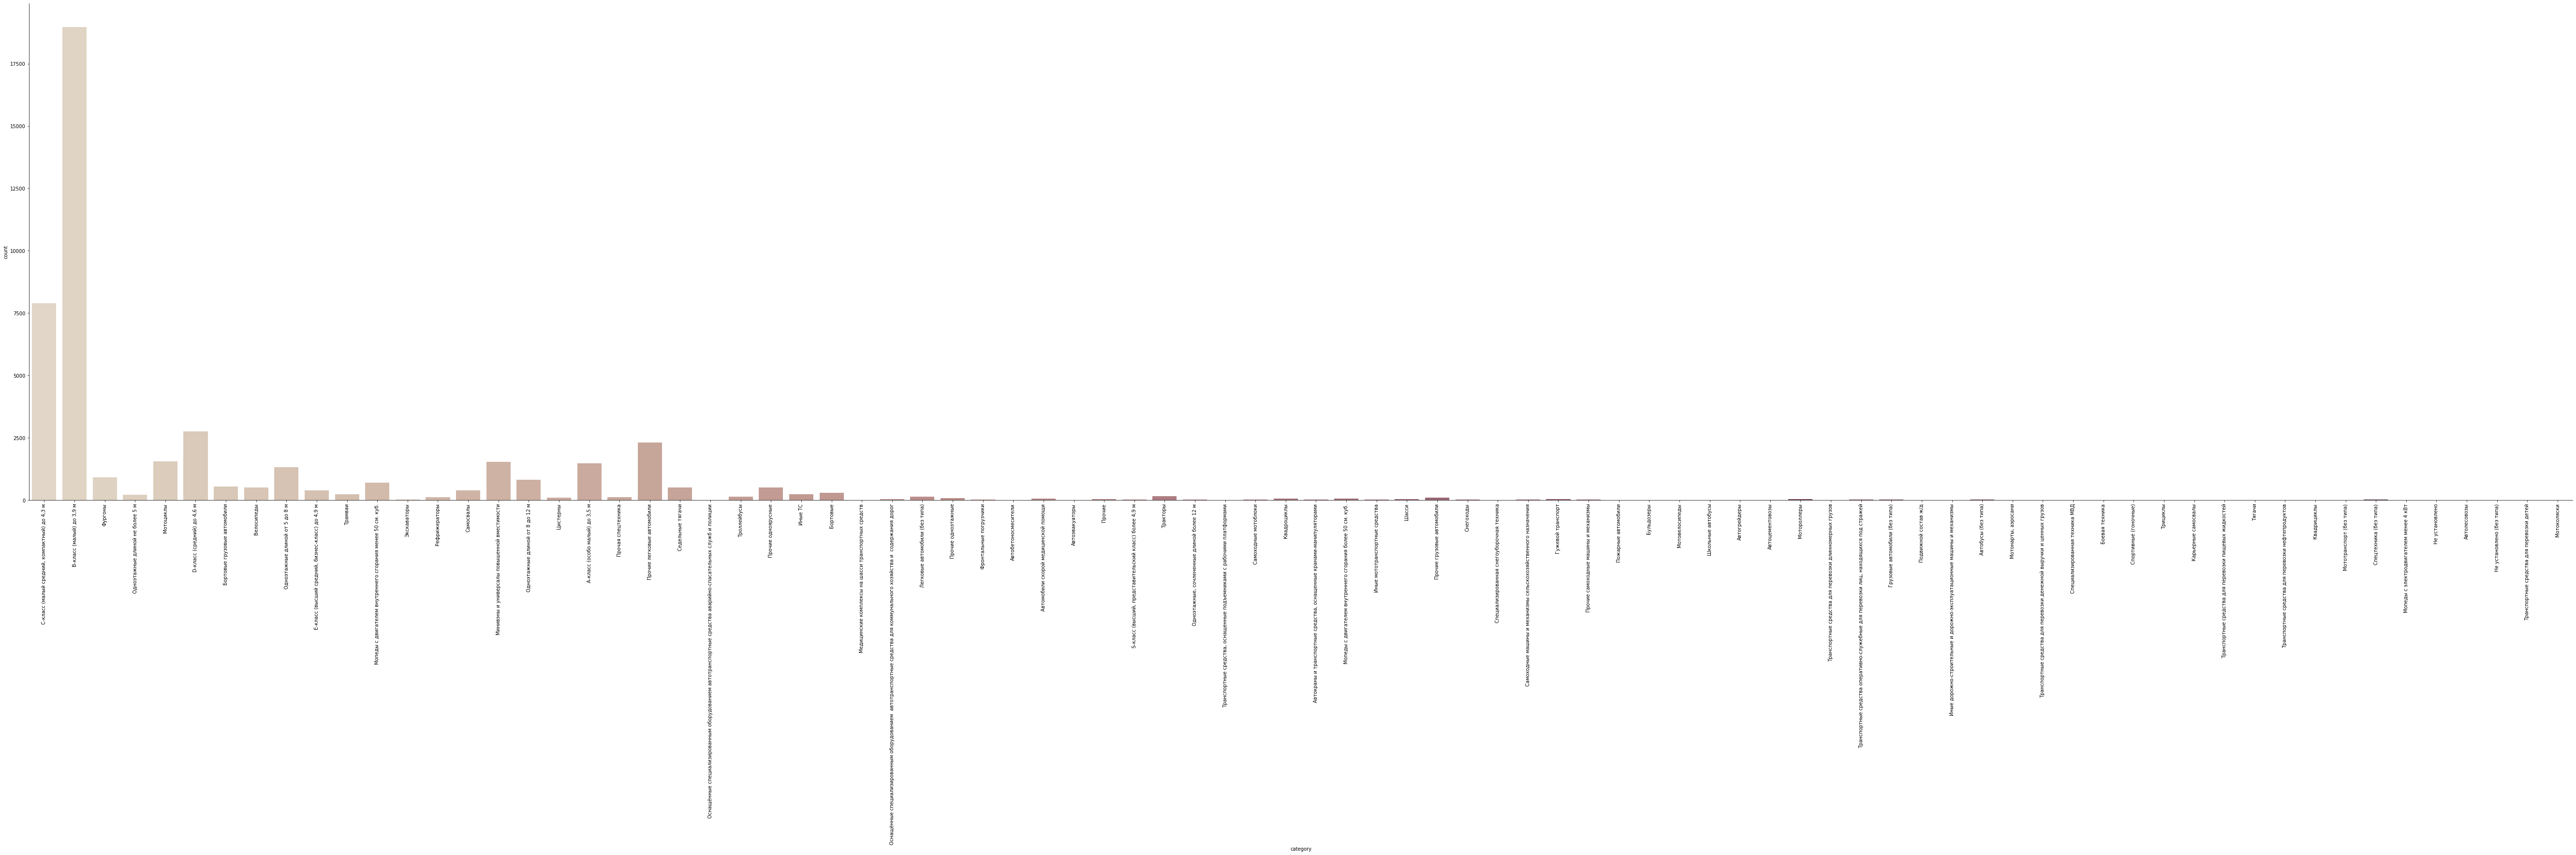

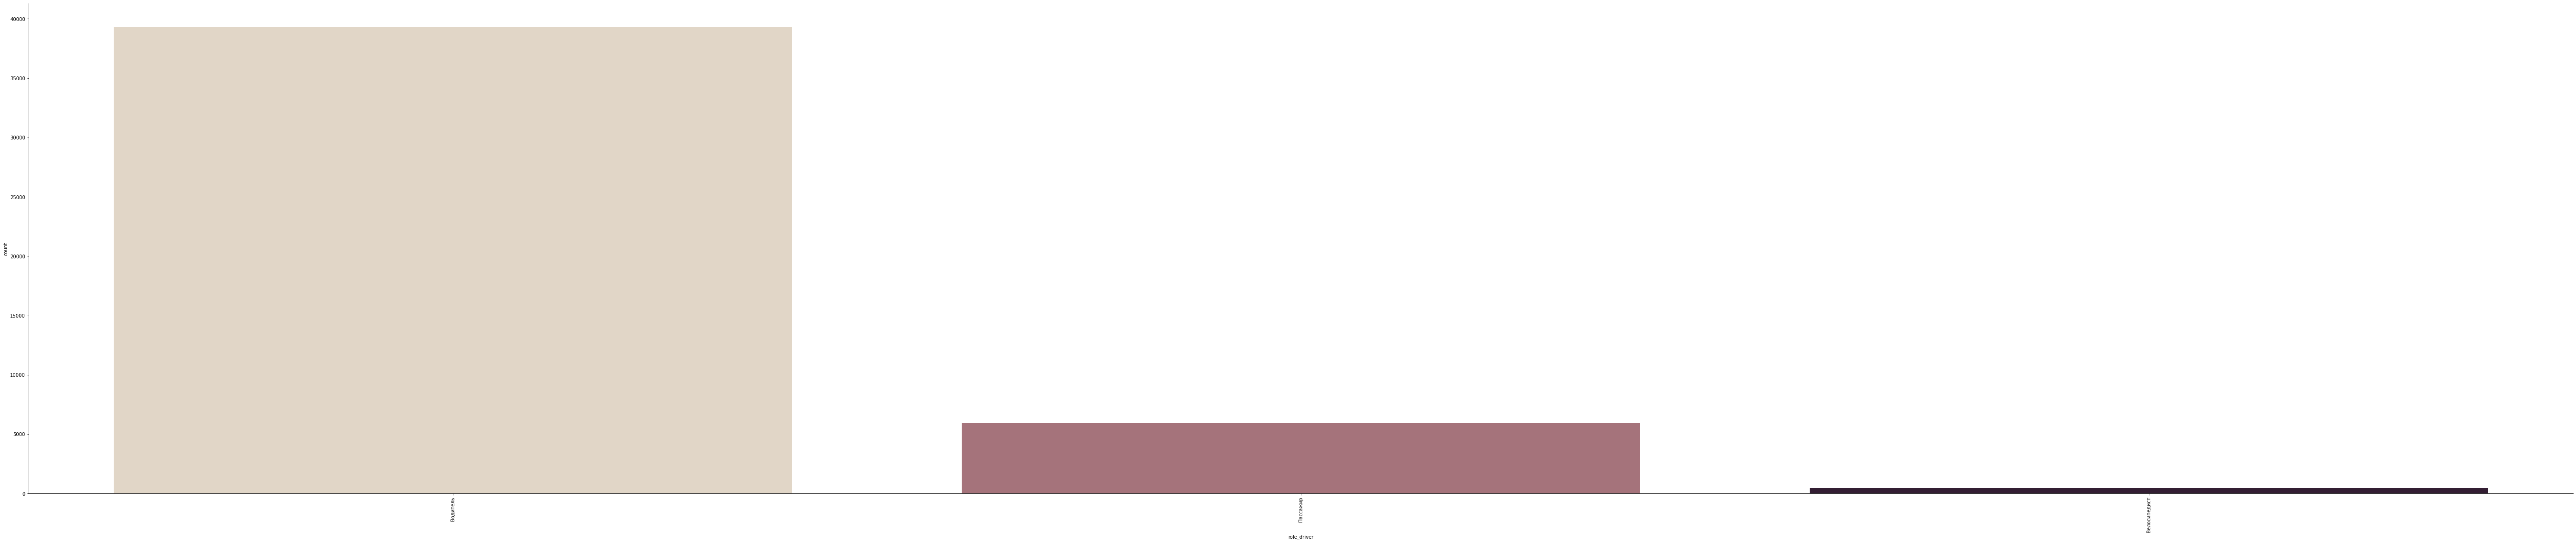

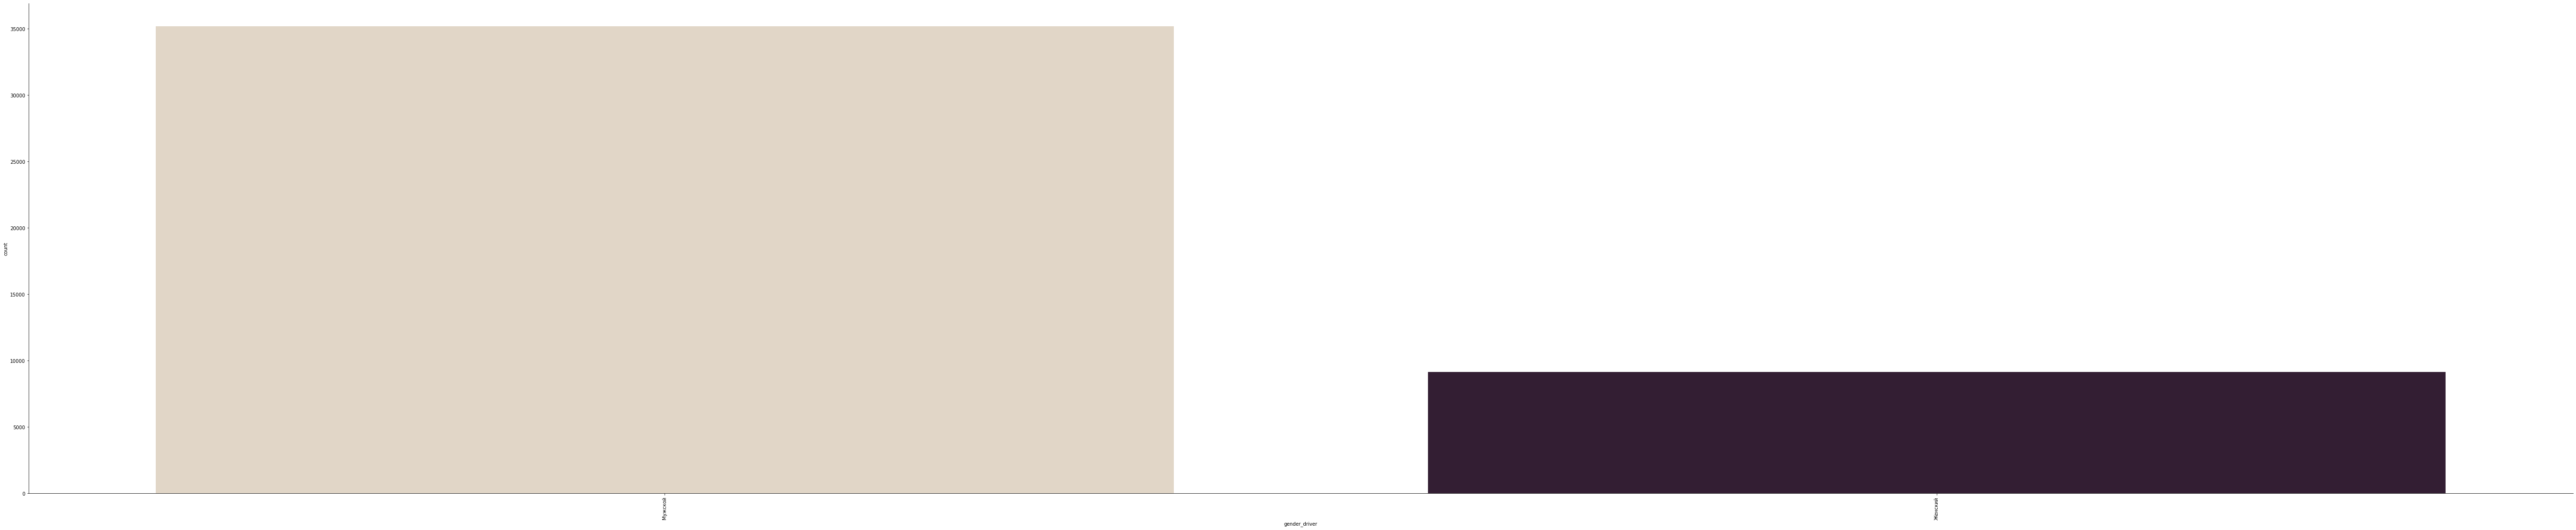

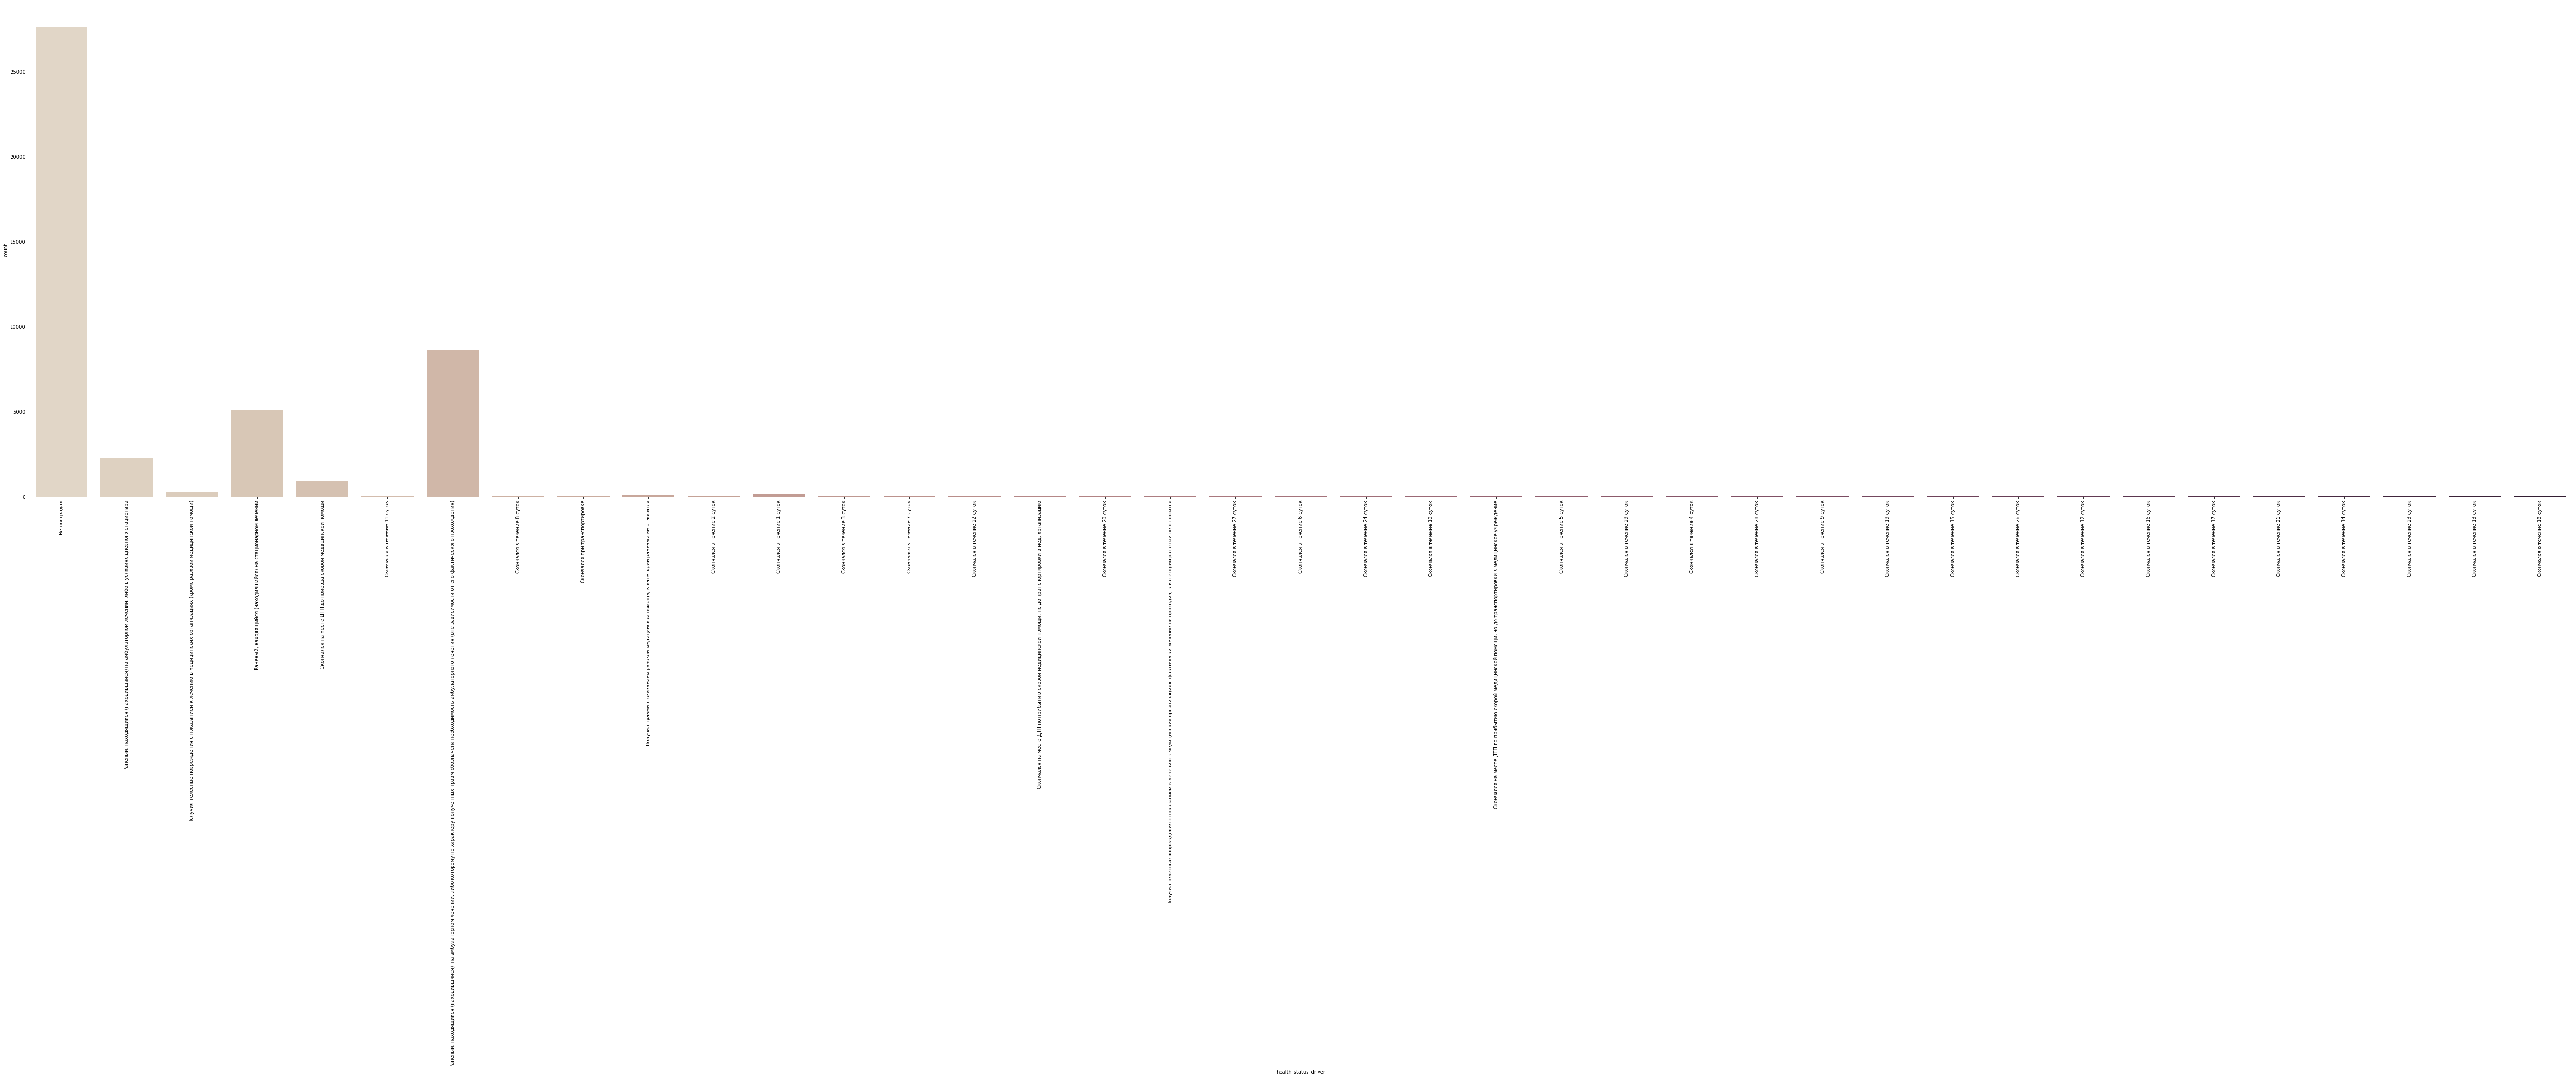

In [12]:
skip = ['properties.id', 'properties.datetime', 'properties.address', 'properties.nearby', 
        'violations_driver', 'properties.tags', 'properties.weather', 'properties.road_conditions', 
        'properties.participant_categories', 'violations_ped','model', 'properties.region']
for i in df.columns:
    if type(df[i].iloc[0]) == str and i not in skip:
        sns.catplot(x=i, kind="count", palette="ch:.25", height=15, aspect=5, data=df) #categorial
        plt.xticks(rotation=90)
        plt.show()

properties.region и model плохо визуализировались в цикле, по этому взял их отдельно

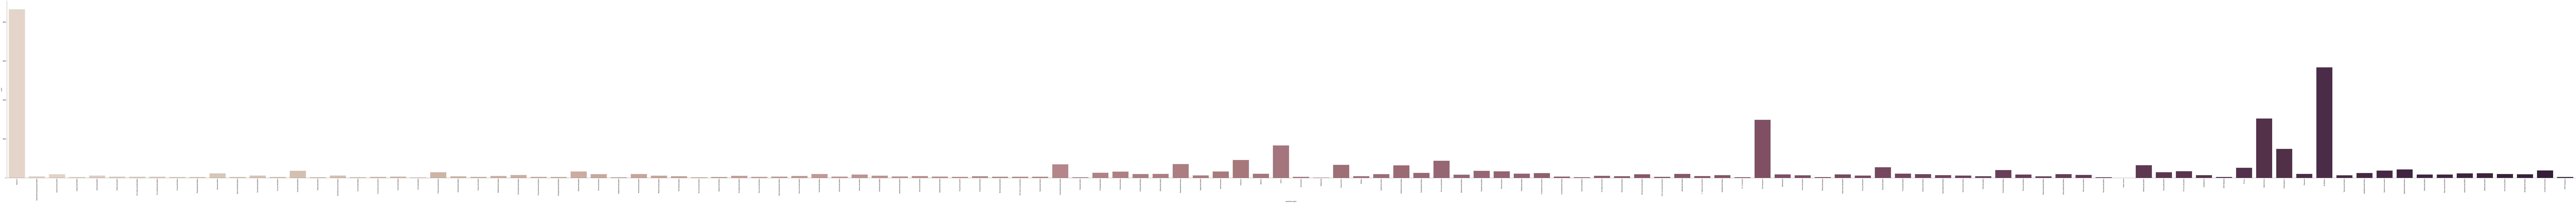

In [13]:
sns.catplot(x='properties.region', kind="count", palette="ch:.25", height=20, aspect=14, data=df) #categorial
plt.xticks(rotation=90)
plt.show()

In [14]:
sns.catplot(x='model', kind="count", palette="ch:.25", height=30, aspect=12, data=df) #categorial
plt.xticks(rotation=90)
plt.show()

На гистограммах выше наблюдается аналогичная ситуация как и со сглаженными распределениями

Заменил все наны на [ ]

In [15]:
df['violations_ped'] = df['violations_ped'].fillna({i: [] for i in df.index})

Плотность распределения списковых значений

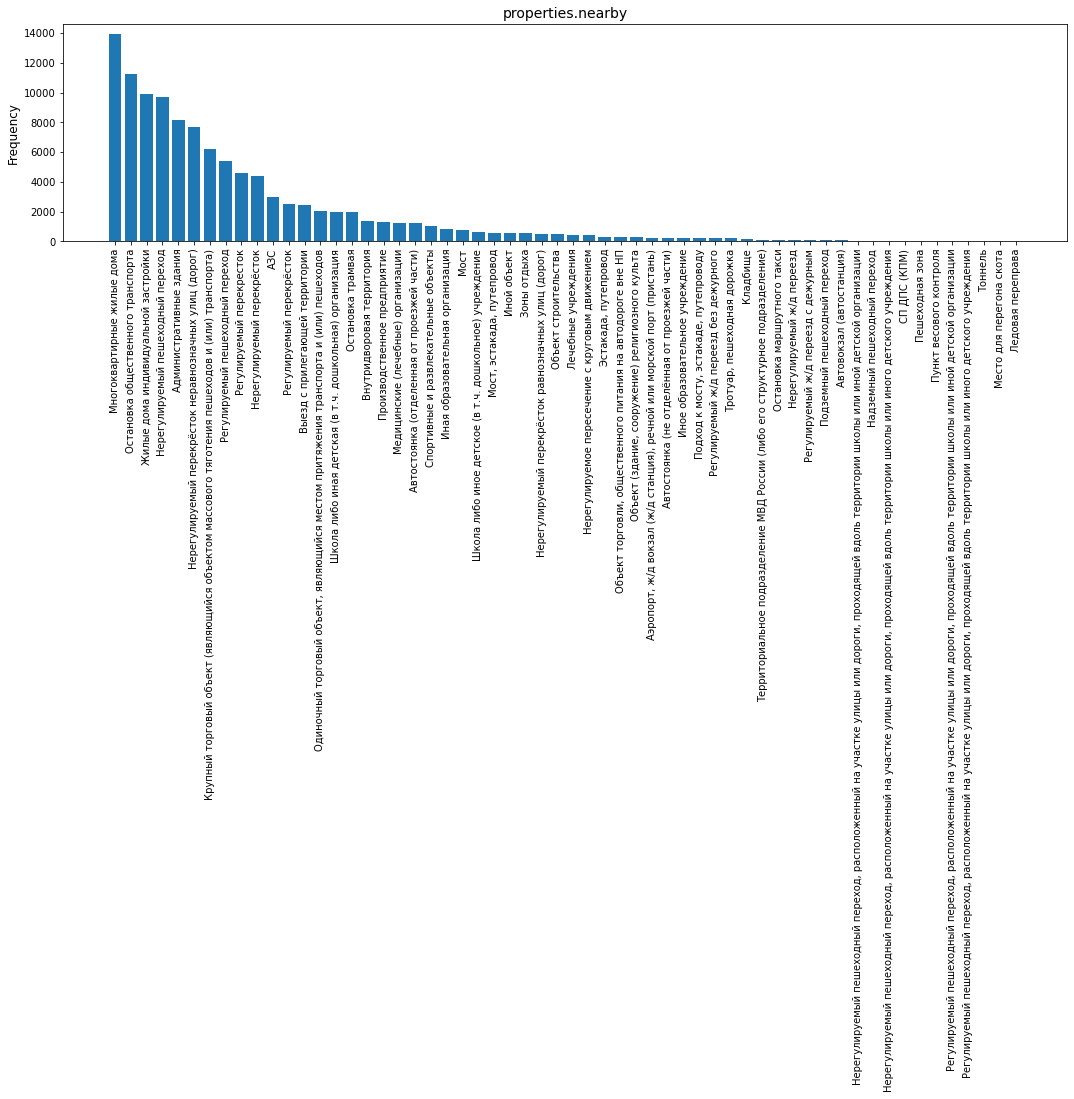

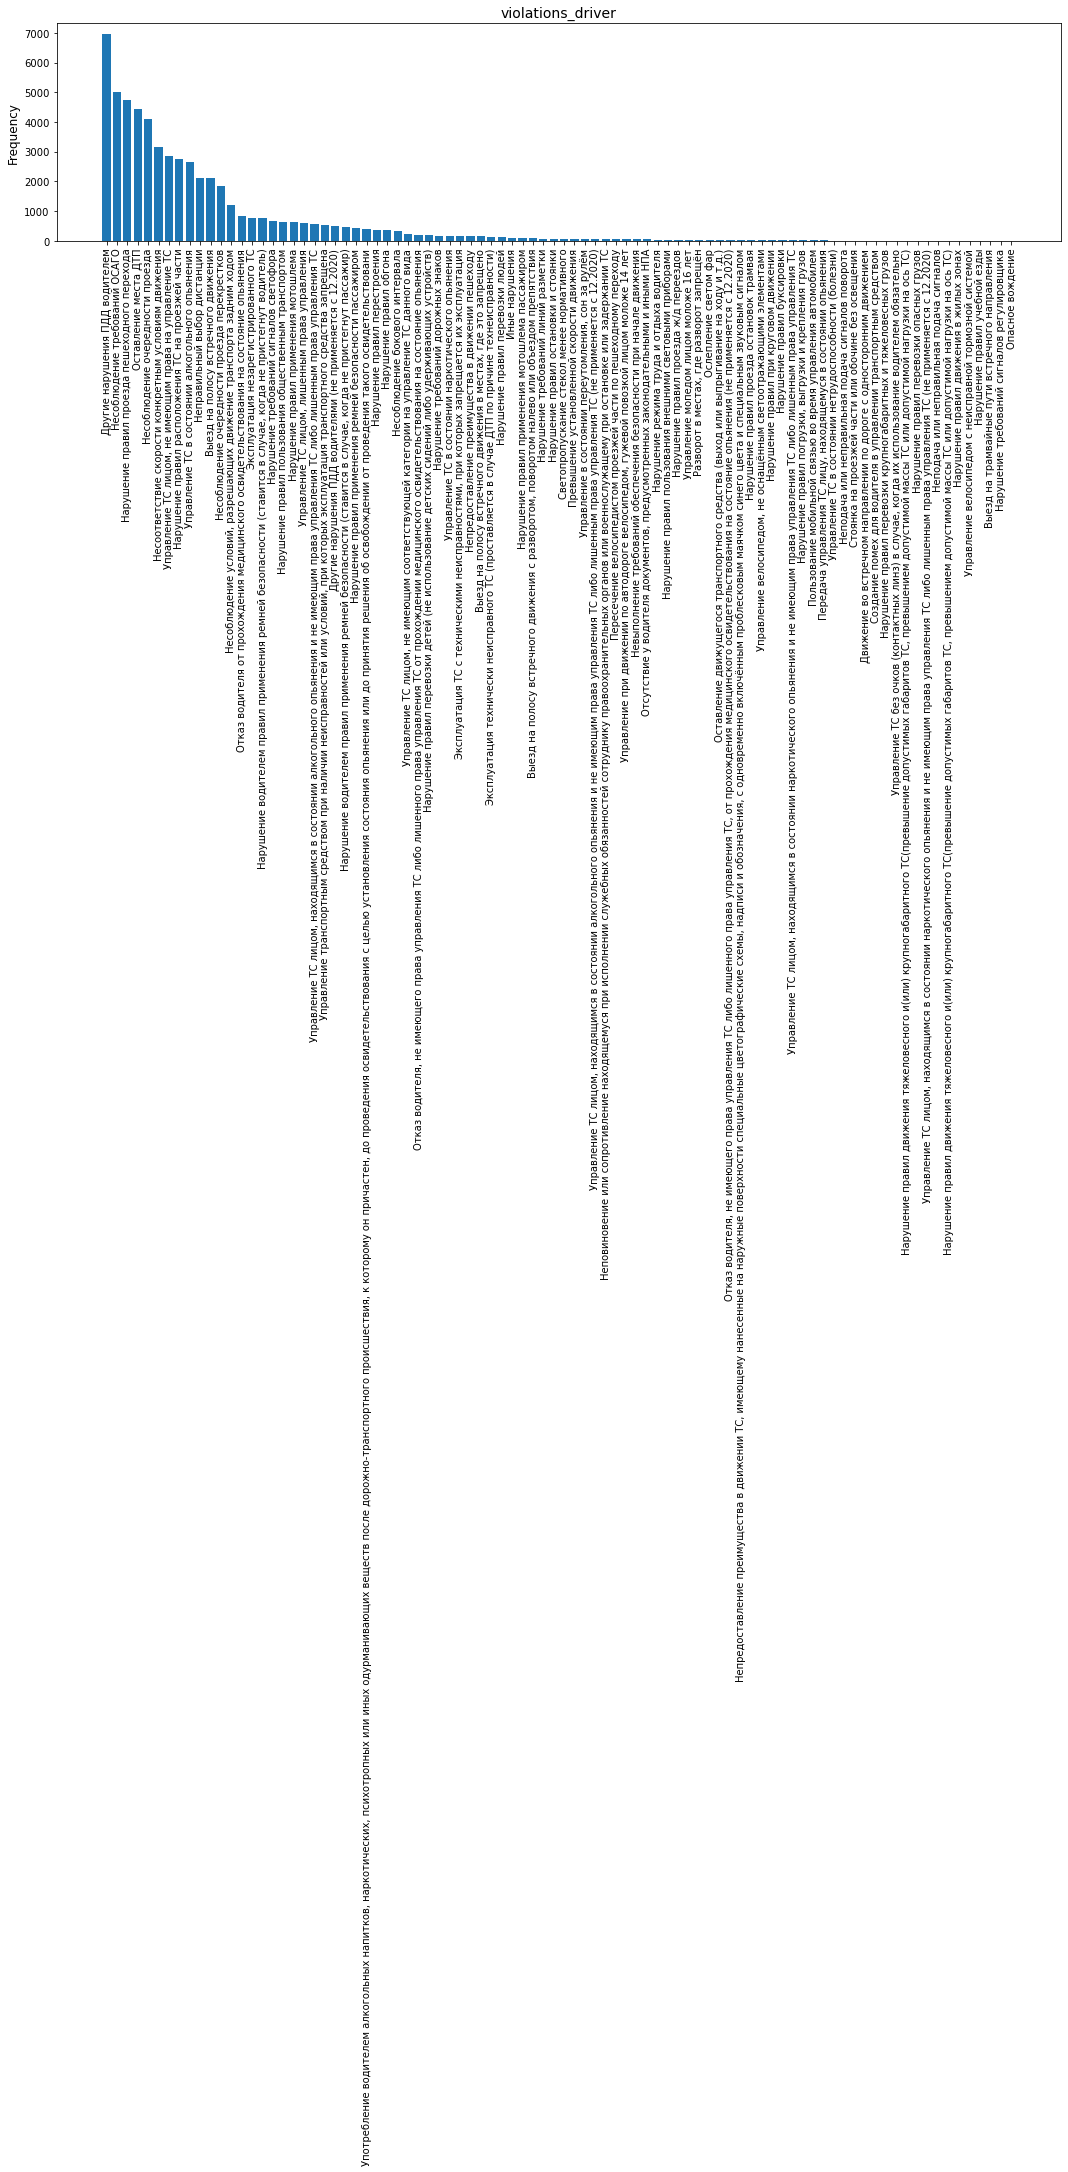

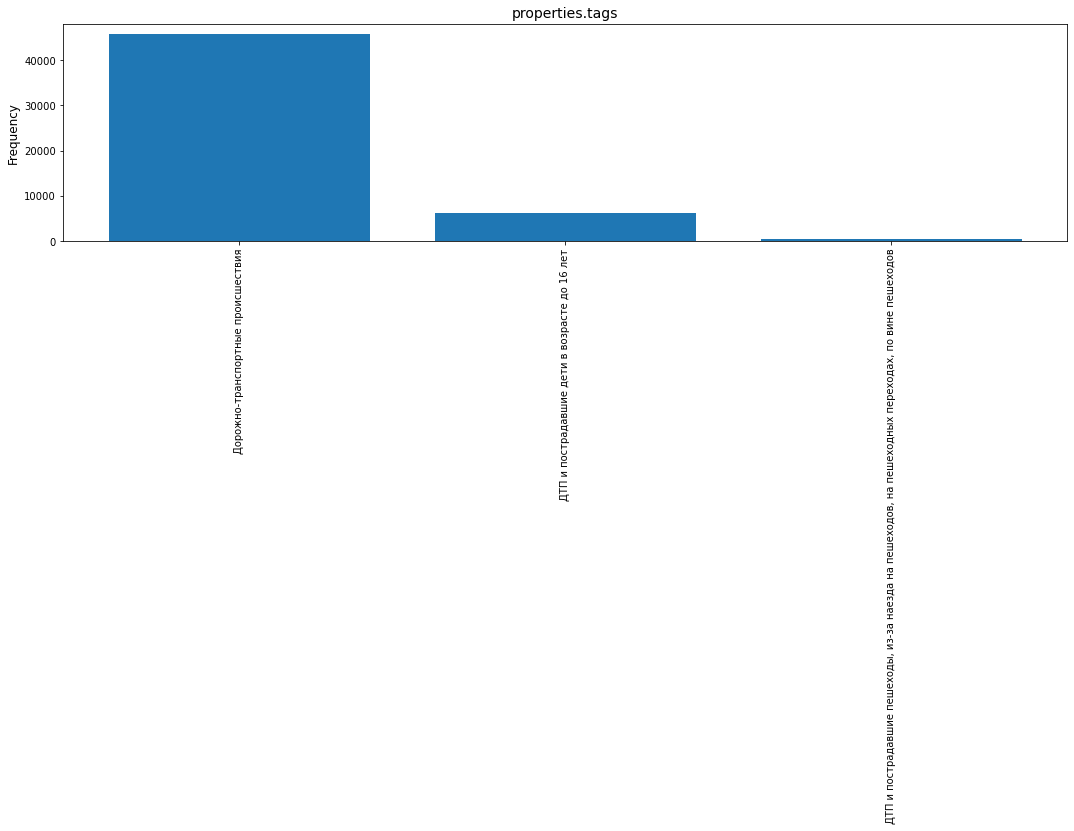

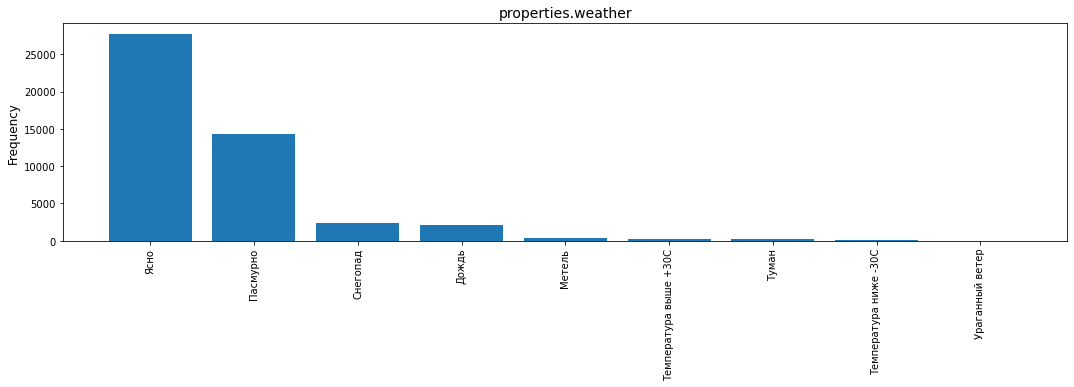

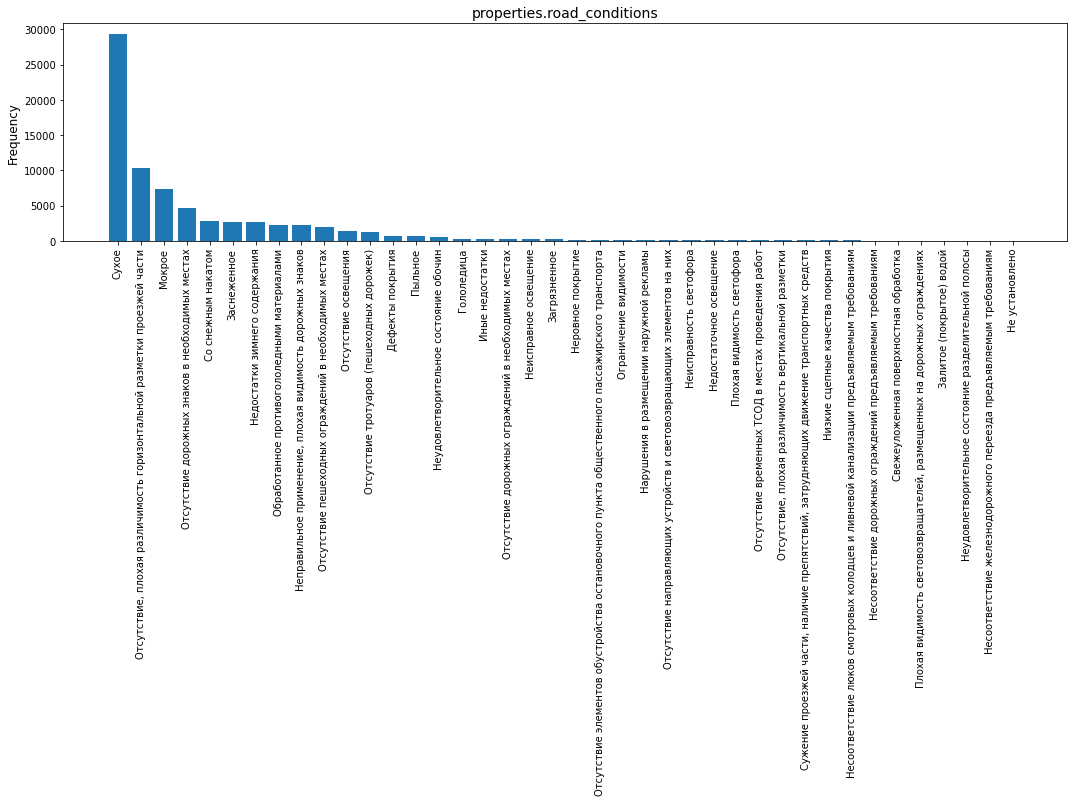

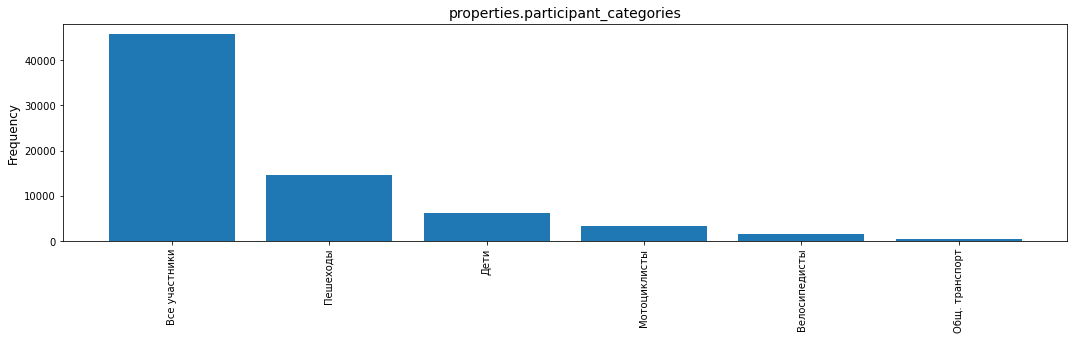

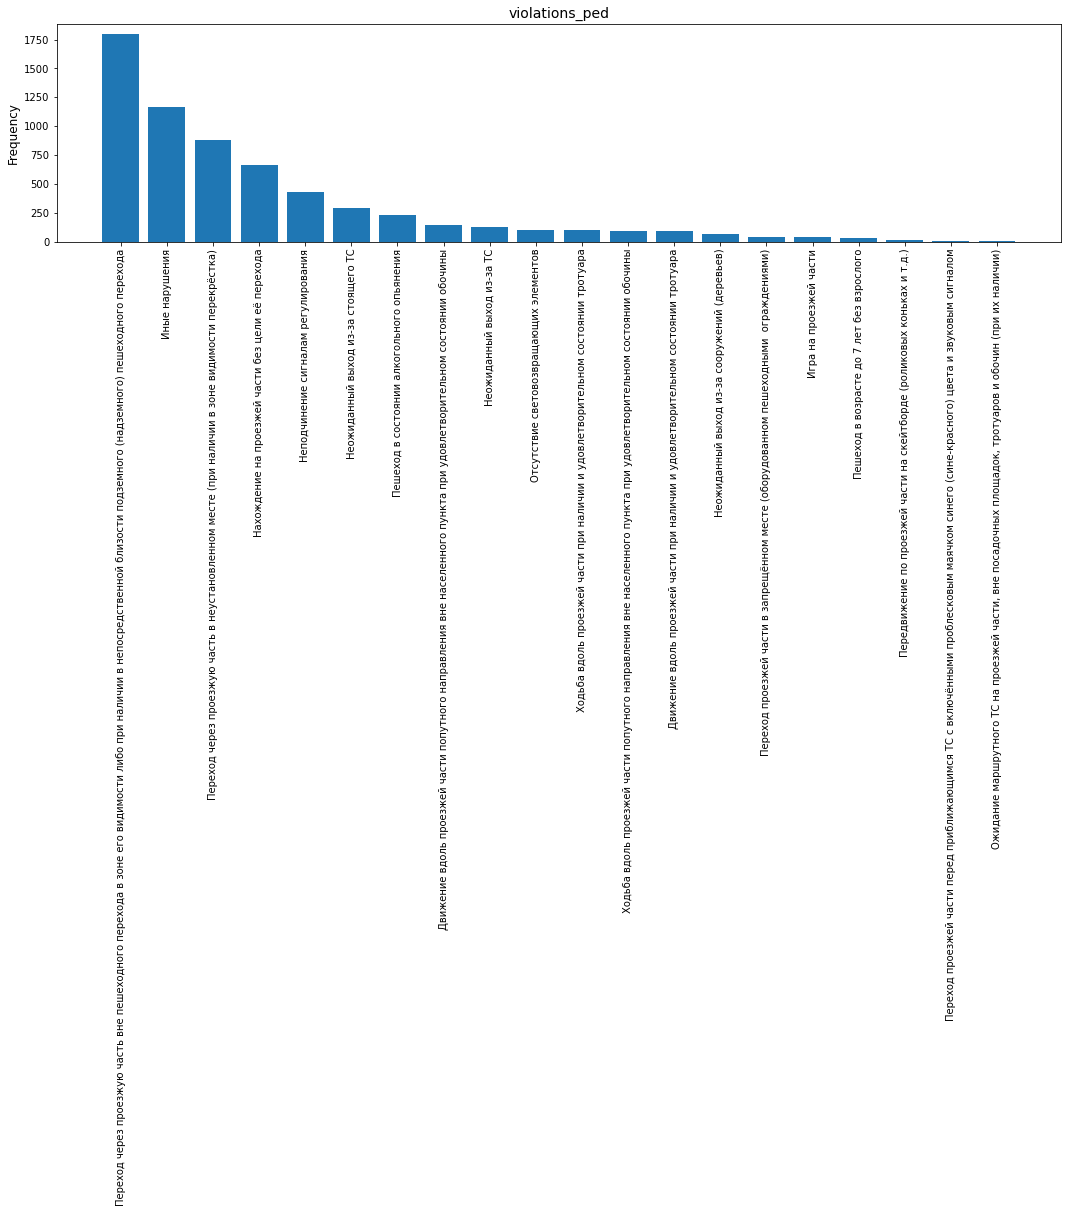

In [16]:
skip = ['properties.nearby', 
        'violations_driver', 'properties.tags', 'properties.weather', 'properties.road_conditions', 
        'properties.participant_categories', 'violations_ped']

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

for i in skip:
    fig, ax = plt.subplots(figsize = (18,4))
    ax.bar(to_1D(df[i]).value_counts().index,
        to_1D(df[i]).value_counts().values)
    ax.set_ylabel("Frequency", size = 12)
    ax.set_title(i, size = 14)
    plt.xticks(rotation=90)
    plt.show()

In [17]:
df.head(2)

,properties.id,properties.tags,properties.light,properties.point.lat,properties.point.long,properties.nearby,properties.region,properties.scheme,properties.address,properties.weather,properties.category,properties.datetime,properties.severity,properties.dead_count,properties.injured_count,properties.parent_region,properties.road_conditions,properties.participants_count,properties.participant_categories,year,brand,color,model,category,role_driver,gender_driver,violations_driver,health_status_driver,years_of_driving_experience,role_ped,gender_ped,violations_ped,health_status_ped
0,2311491,[Дорожно-транспортные происшествия],"В темное время суток, освещение отсутствует",53.342000,83.690300,"[Многоквартирные жилые дома, Административные ...",Барнаул,610,"г Барнаул, тракт Павловский, 249 а",[Ясно],Наезд на препятствие,2017-09-04 22:15:00,Легкий,0,1,Алтайский край,[Сухое],2,[Все участники],2002.0,TOYOTA,Черный,Camry,"С-класс (малый средний, компактный) до 4,3 м",Водитель,Мужской,"[Другие нарушения ПДД водителем, Нарушение вод...",Не пострадал,NaN,NaN,NaN,[],NaN
1,2489516,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.369248,83.699802,"[Многоквартирные жилые дома, Нерегулируемый пе...",Барнаул,300,"г Барнаул, ул Юрина, 241",[Дождь],Столкновение,2020-09-24 09:30:00,Легкий,0,2,Алтайский край,[Мокрое],3,"[Дети, Все участники]",2006.0,SUBARU,Серый,Forester,"В-класс (малый) до 3,9 м",Водитель,Мужской,[Несоответствие скорости конкретным условиям д...,"Раненый, находящийся (находившийся) на амбулат...",12.0,NaN,NaN,[],NaN


### 1.3 Описание структуры набора данных

"properties.id": 384094, # идентификатор <br>
"properties.tags": ["Дорожно-транспортные происшествия"], # показатели с официального сайта ГИБДД<br>
"properties.light": "Светлое время суток", # время суток<br>
"properties.point.lat, properties.point.long": {"lat": 50.6039, "long": 36.5578}, # координаты<br>
"properties.nearby": [ "Нерегулируемый перекрёсток неравнозначных улиц (дорог)", "Жилые дома индивидуальной застройки"], # координаты<br>
"properties.region": "Белгород", # город/район<br>
"properties.address": "г Белгород, ул Сумская, 30", # адрес<br>
"properties.weather": ["Ясно"], # погода<br>
"properties.category": "Столкновение", # тип ДТП<br>
"properties.datetime": "2017-08-05 13:06:00", # дата и время<br>
"properties.severity": "Легкий", # тяжесть ДТП/вред здоровью<br>
properties."vehicles": [ # участники – транспортные средства<br>
    
"year": 2010, # год производства транспортного средства<br>
"brand": "ВАЗ", # марка транспортного средства<br>
"color": "Иные цвета", # цвет транспортного средства<br>
"model": "Priora", # модель транспортного средства<br>
"category": "С-класс (малый средний, компактный) до 4,3 м", # категория транспортного средства<br>
"participants": [ # участники внутри транспортных средств<br>

"role_driver": "Водитель", # роль участника<br>
"gender_driver": "Женский", # пол участника<br>
"violations_driver": [], # нарушения правил участником<br>
"health_status_driver": "Раненый, находящийся...", # состояние здоровья участника<br>
"years_of_driving_experience": 11 # стаж вождения участника (только у водителей)<br>

"properties.dead_count": 0, # кол-во погибших в ДТП<br>
"properties.participants": [], # участники без транспортных средств (описание, как у участников внутри транспортных средств)<br>

"role_ped": "Водитель", # роль участника<br>
"gender_ped": "Женский", # пол участника<br>
"violations_ped": [], # нарушения правил участником<br>
"health_status_ped": "Раненый, находящийся...", # состояние здоровья участника<br>

"properties.injured_count": 2, # кол-во раненых в ДТП<br>
"properties.parent_region": "Белгородская область", # регион<br>
"properties.road_conditions": ["Сухое"], # состояние дорожного покрытия<br>
"properties.participants_count": 3, # кол-во участников ДТП<br>
"properties.participant_categories": ["Все участники", "Дети"] # категории участников<br>

#### Некоторые атрибуты имеют списочнене значения по этому их надо разбить

Замена все нанов на не указано

In [18]:
df['gender_ped'].fillna('нет', inplace=True)
df['year'].fillna(2000, inplace=True)
df['properties.scheme'].fillna(0, inplace=True)
df.fillna('не указано', inplace=True)

Парсинг списковых значений

In [19]:
def listParse(df, column, suf=''):    
    v = df[column].values
    l = [len(x) for x in v.tolist()]
    f, u = pd.factorize(np.concatenate(v))
    n, m = len(v), u.size
    i = np.arange(n).repeat(l)

    dummies = pd.DataFrame(
        np.bincount(i * m + f, minlength=n * m).reshape(n, m),
        df.index, u
    )
    return df.drop(column, axis=1).join(dummies, rsuffix=suf)

In [20]:
df = listParse(df, 'properties.nearby')
df = listParse(df, 'violations_driver')
df = listParse(df, 'properties.tags')
df = listParse(df, 'properties.weather')
df = listParse(df, 'properties.road_conditions')
df = listParse(df, 'properties.participant_categories')
df = listParse(df, 'violations_ped', '_ped')

In [21]:
df

,properties.id,properties.light,properties.point.lat,properties.point.long,properties.region,properties.scheme,properties.address,properties.category,properties.datetime,properties.severity,properties.dead_count,properties.injured_count,properties.parent_region,properties.participants_count,year,brand,color,model,category,role_driver,gender_driver,health_status_driver,years_of_driving_experience,role_ped,gender_ped,health_status_ped,Многоквартирные жилые дома,Административные здания,АЗС,Нерегулируемый пешеходный переход,"Одиночный торговый объект, являющийся местом притяжения транспорта и (или) пешеходов",Школа либо иная детская (в т.ч. дошкольная) организация,"Нерегулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иной детской организации",Жилые дома индивидуальной застройки,Нерегулируемый перекрёсток,Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта),Нерегулируемый перекрёсток неравнозначных улиц (дорог),Регулируемый перекресток,Регулируемый пешеходный переход,Спортивные и развлекательные объекты,"Аэропорт, ж/д вокзал (ж/д станция), речной или морской порт (пристань)",Остановка общественного транспорта,Нерегулируемое пересечение с круговым движением,Медицинские (лечебные) организации,Выезд с прилегающей территории,Иной объект,Иная образовательная организация,Остановка трамвая,Внутридворовая территория,Зоны отдыха,Объект строительства,Регулируемый перекрёсток,Производственное предприятие,Автостоянка (отделенная от проезжей части),Мост,Автостоянка (не отделённая от проезжей части),Нерегулируемый перекрёсток равнозначных улиц (дорог),"Мост, эстакада, путепровод",Школа либо иное детское (в т.ч. дошкольное) учреждение,"Объект (здание, сооружение) религиозного культа",Регулируемый ж/д переезд с дежурным,Надземный пешеходный переход,"Подход к мосту, эстакаде, путепроводу",Регулируемый ж/д переезд без дежурного,Подземный пешеходный переход,Кладбище,Лечебные учреждения,"Тротуар, пешеходная дорожка",Иное образовательное учреждение,Территориальное подразделение МВД России (либо его структурное подразделение),СП ДПС (КПМ),"Эстакада, путепровод",Автовокзал (автостанция),Нерегулируемый ж/д переезд,"Регулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иной детской организации","Нерегулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иного детского учреждения","Объект торговли, общественного питания на автодороге вне НП",Остановка маршрутного такси,"Регулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иного детского учреждения",Место для перегона скота,Пункт весового контроля,Тоннель,Пешеходная зона,Ледовая переправа,Другие нарушения ПДД водителем,"Нарушение водителем правил применения ремней безопасности (ставится в случае, когда не пристегнут пассажир)",Несоответствие скорости конкретным условиям движения,Несоблюдение требований ОСАГО,Нарушение правил проезда пешеходного перехода,Несоблюдение очередности проезда,Оставление места ДТП,Нарушение правил перестроения,Нарушение правил пользования общественным транспортом,Невыполнение требований обеспечения безопасности при начале движения,Выезд на полосу встречного движения,"Управление ТС лицом, не имеющим права на управление ТС",Нарушение правил расположения ТС на проезжей части,Несоблюдение бокового интервала,Неправильный выбор дистанции,Нарушение правил проезда остановок трамвая,Эксплуатация незарегистрированного ТС,"Отсутствие у водителя документов, предусмотренных законодательными и иными НПА","Несоблюдение условий, разрешающих движение транспорта задним ходом",Управление ТС в состоянии наркотического опьянения,Нарушение требований сигналов светофора,Управление ТС в состоянии алкогольного опьянения,Непредоставление преимущества в движении пешеходу,"Управление транспортным средством при наличии неисправностей

Нашел наиболее значимые признаки

In [22]:
fs = FeatureSelector(data = df)

fs.identify_collinear(correlation_threshold=0.1)
correlated_features = fs.ops['collinear']

No labels provided. Feature importance based methods are not available.
98 features with a correlation magnitude greater than 0.10.



In [23]:
correlated_features

['properties.point.lat',
 'properties.point.long',
 'properties.injured_count',
 'properties.participants_count',
 'Многоквартирные жилые дома',
 'Административные здания',
 'Нерегулируемый пешеходный переход',
 'Одиночный торговый объект, являющийся местом притяжения транспорта и (или) пешеходов',
 'Нерегулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иной детской организации',
 'Жилые дома индивидуальной застройки',
 'Нерегулируемый перекрёсток',
 'Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта)',
 'Нерегулируемый перекрёсток неравнозначных улиц (дорог)',
 'Регулируемый перекресток',
 'Регулируемый пешеходный переход',
 'Остановка общественного транспорта',
 'Медицинские (лечебные) организации',
 'Иная образовательная организация',
 'Остановка трамвая',
 'Внутридворовая территория',
 'Регулируемый перекрёсток',
 'Автостоянка (отделенная от проезжей части)',
 'Подход к мосту, 

### 1.4 Подготовка отчета

В ходе работы было выполнено:
* 1.1 Парсинг данных - Преобразование документов из geojsob в pandas dataFrame;
* 1.2 Предобработка данных и выделение значимых атрибутов - устранение дубликатов у id, а так же удалены строки в которых не указаны координаты; Проанализированны наны; Проанализированна плотность заполнения атрибутов;
* 1.3 Описание структуры набора данных - Описан набор данных; Выделены значимые атрибуты;

In [24]:
df.to_csv('output.csv', index=False, encoding='utf-8-sig')